In [1]:
%pylab inline

import os
from astropy.io import fits

from styles.slides import *
from styles.colors import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
def SNR_spec(F, t, L=5500., h=0.25, R=1800., D=3., nr=3., sigma=4., ps=0.396):
    fl = F*L*h*t
    bg = fl*0.1                     #assuming a background dominated observation
    rd = 2*R*D/ps * nr*sigma**2
    return fl/sqrt(bg + rd)

def SNR_phot(F, t, dlambda=100, h=0.5, nf=56, D=3, nr=4, sigma=4, ps=0.396):
    fl = F*dlambda*h*t
    bg = fl*0.1
    rd = nf*pi*(0.5*D/ps)**2*nr*sigma**2
    return fl/sqrt(bg + rd)

def photon_count(wlen, flux):
    c = 3e8
    h = 6.62e-27
    return (wlen*1e-10)*(flux/(c*h))

def bar_F(SNR, t=900., L=5500., h=0.25, R=1800., D=3., nr=3., sigma=4., ps=0.396):
    return (SNR**2+sqrt(SNR**4+4*(2*R*D)/ps*nr*sigma**2*SNR**2))/(2*L*h*t)

True


(array([    0.,     7.,   211.,  1441.,  4434.,  5098.,  1378.,   335.,
            0.,     0.]),
 array([ 15. ,  15.6,  16.2,  16.8,  17.4,  18. ,  18.6,  19.2,  19.8,
         20.4,  21. ]),
 <a list of 10 Patch objects>)

/home/mejia/Programs/miniconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Roboto'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


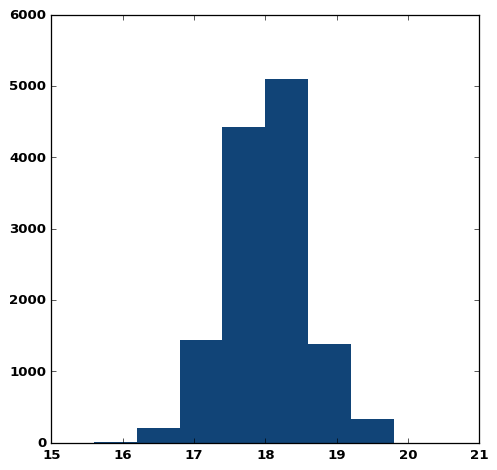

In [3]:
#download and load spectroscopic throughput from SDSS
#load tables
snr = genfromtxt("data/RealDeal/snr_spec.txt", dtype=None, names=True)
cat = genfromtxt("data/RealDeal/catalog.txt", dtype=None, names=True)

_in_snr = array([i for i in xrange(cat.size) if cat["input_file"][i] in snr["input_file"]], dtype=np.int)

cat = cat[_in_snr]

snr[cat["u_mag"]>0]
cat[cat["u_mag"]>0]

print all(snr["input_file"]==cat["input_file"])

hist(cat["r_mag"], range=(15,21))

In [4]:
#select one galaxy in r=16,18,20 bins
bins = percentile(cat["r_mag"], [5,50,95])

true_snr = [snr["snr_wall"][argmin(abs(mag-cat["r_mag"]))] for mag in bins]
isort = argsort(true_snr)
true_snr = np.sort(true_snr)

spec_name = array([cat["input_file"][argmin(abs(mag-cat["r_mag"]))] for mag in bins])[isort]
true_mag = array([cat["r_mag"][argmin(abs(mag-cat["r_mag"]))] for mag in bins])[isort]

#get relevant data from FITS: expTime, readout noise, etc.
fdir = os.path.expandvars("$phd/inputs/real_deal/fits/")
spec_fits = [fits.open(fdir+fit) for fit in spec_name]
spec_expt = [f[0].header["EXPTIME"] for f in spec_fits]
spec_nr = [int(expt/60./15.) for expt in spec_expt]

print spec_name
print true_mag
print true_snr
print spec_expt
print spec_nr

['spSpec-51876-0394-610.fit' 'spSpec-51990-0310-459.fit'
 'spSpec-52178-0662-550.fit']
[ 19.0521  18.0314  17.0769]
[ 10.    16.22  32.09]
[5100.0, 2701.0, 3003.0]
[5, 3, 3]


In [5]:
# spec_npho, spec_snr = [], []
# F_spec = []
# for i,f in enumerate(spec_fits):
#     #read original (observed SED)
#     wlen = array([10**(f[0].header["COEFF0"]+f[0].header["COEFF1"]*j) for j in xrange(f[0].header["NAXIS1"])])
#     wlen /= 1.0 + 2.735182E-4 + 131.4182 / wlen**2 + 2.76249E8 / wlen**4
#     flux = f[0].data[0]*1e-17
#     wlen = wlen[flux>0]
#     flux = flux[flux>0]
#     #compute spectroscopic F = mean(F_lambda*R)
#     spec_npho.append(photon_count(wlen,flux))
#     F_spec.append(spec_npho[-1])
#     spec_snr.append(SNR_spec(F_spec[i], t=spec_expt[i], nr=spec_nr[i], L=wlen.max()-wlen.min()))

In [6]:
F_spec = []
for i,f in enumerate(spec_fits):
    #read original (observed SED)
    wlen = array([10**(f[0].header["COEFF0"]+f[0].header["COEFF1"]*j) for j in xrange(f[0].header["NAXIS1"])])
    wlen /= 1.0 + 2.735182E-4 + 131.4182 / wlen**2 + 2.76249E8 / wlen**4
    flux = f[0].data[0]*1e-17
    wlen = wlen[flux>0]
    flux = flux[flux>0]
    #compute spectroscopic F = mean(F_lambda*h_s)
    F_spec.append(bar_F(true_snr[i], t=spec_expt[i], nr=spec_nr[i], L=wlen.max()-wlen.min()))
    #using the expTime, reproduce the reported SNR values
    print SNR_spec(F_spec[i], t=spec_expt[i], nr=spec_nr[i], L=wlen.max()-wlen.min())

10.0305011765
16.3237293284
32.4969849444


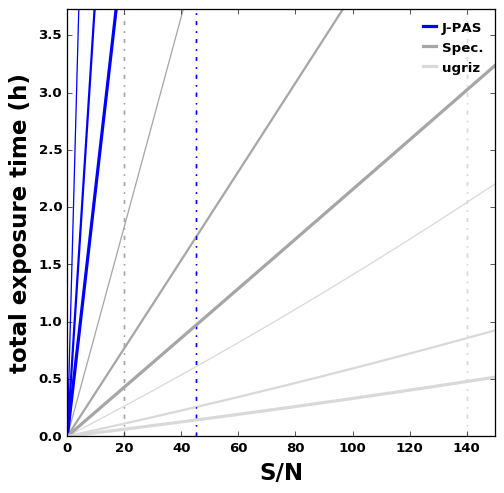

In [17]:
#compute photometric F = sum(F_i*h_i)/nf ~ F_spec for the J-PAS filter set
F_pho = F_spec

tt = linspace(5.0, 60*4*56., 100000)
lws = [1, 1.75, 2.5]
for i in xrange(len(spec_name)):
    #compute the J-PAS SNR using the instrument values from Benitez et al. 2014
    SNR_jpas = lambda t: SNR_phot(F_pho[i], t, dlambda=140., h=0.7, nf=56., D=3., nr=4., sigma=4., ps=0.2267)
    #also plot SDSS photometry for comparison
    SNR_ugriz = lambda t: SNR_phot(F_pho[i], t, dlambda=1200., h=0.5, nf=5., D=3., nr=1., sigma=4., ps=0.396)
    #plot the SNR vs. t for the SDSS spectra and for the J-PAS
    SNR_sdss = lambda t: SNR_spec(F_spec[i], t, L=5400., h=0.3, nr=3.)

    axvline(45., ls="-.", color="b", lw=1)
    axvline(20., ls="-.", color="0.65", lw=1)
    axvline(140, ls="-.", color="0.85", lw=1)

    if i==2:
        plot(SNR_jpas(tt), tt/3600, "-", color="b", lw=lws[i], label="J-PAS")
        plot(SNR_sdss(tt), tt/3600, "-", color="0.65", lw=lws[i], label="Spec.")
        plot(SNR_ugriz(tt), tt/3600, "-", color="0.85", lw=lws[i], label="ugriz")
    else:
        plot(SNR_jpas(tt), tt/3600, "-", color="b", lw=lws[i])
        plot(SNR_sdss(tt), tt/3600, "-", color="0.65", lw=lws[i])
        plot(SNR_ugriz(tt), tt/3600, "-", color="0.85", lw=lws[i])

legend(loc=1)
xlim(0,150)
ylim(0,tt.max()/3600)

xlabel(r"S/N")
ylabel(r"total exposure time (h)")

# $S/N$ proof Summary

Three different sources with spectral energy distribution (SED) $f_\lambda$ were studied, with fiber $r$-magnitude $19.0521$, $18.0314$, and $17.0769\,$mag and corresponding $S/N\approx10$, $16$, and $32$ (thick, medium and thin line, respectively). The average photon count, $\bar{F}$ measured by the instrument was cumputed using the SDSS spectrograph set up: $\eta=0.25$, $L=5500\,$Angströms, $p_s=0.396\,$arcsec/pixel, $R=1800$, and $\sigma_r=4\,$e$^{-}$; in all cases assuming a background dominated observation and using as input $S/N$ the one computed over all wavelengths. The number of exposures and the total exposure time ($t_\text{exp}\times n_r$) were read from the SDSS-DR7 FITS (1d) files to ensure a realistic estimation of the photon count.

Using the same value $\bar{F}$, the corresponding $S/N$ values were computed for photometric observations using the J-PAS camera set up: $\eta=0.7$, d$\lambda\approx140\,$Angströms, $p_s=0.2267\,$arcsec/pixel, $56+14$ filters (first scan with all filters plus another scan of the last tray containing only 14 filters), $nr=4$, and $\sigma=4\,$e$^{-}$.

A comparison of the total exposure time in hours as a function of the required $S/N$ is shown in the plot for the three different sources assuming the two instrumental set ups aforementioned. The upper limit in time represents the minimum exposure time planned for the J-PAS. It is clear that J-PAS will take longer exposures to reach the assumed $S/N=45$ in mock simulations, even with the brighter source ($r\sim17\,$mag) used in this example.

## Referee questions

##### Presumably $S/N=45$ for spectroscopy would yield better results than for narrow-band photometry?
Yes, in particular the precision is tightly related to the $S/N$. The better $S/N$ the better physical parameter precision. The biases are expected to fall too down to a minimum value where physical assumptions in the modelling are expected to dominate.

##### $S/N=20$ for the photometry might result in larger biases?
Yes, the same as above apply also in this case.

##### Is it really cheaper to get $S/N=45$ in $56$ bands than $S/N=20$ spectroscopy with a multiplexed spectrograph?
The plot above seems to point to a plane "no" to answer this question. Nevertheless, the most important factor to decide which type of observation is cheaper is the survey speed, i.e., the number of objects of interest observed per total exposure time. Multiplexed spectroscopy surveys are typically $\sim1000$ (the SDSS-DR7 instruments were $640$ sources per exposure), mostly due to engineering limitations. On the other hand, photometric survey speed depend mostly on the field of view (FOV). In particular the J-PAS main instrument will have a FOV$\sim3$ square degrees (similar to the SDSS imaging camera), the expected number of galaxies per exposure is $>10^4$. So in the long run, J-PAS will be cheaper than tranditional multiplexed spectroscopy.

##### Is $S/N=45$ the typical expected $S/N$ of the J-PAS survey?
Local bright galaxies will require longer than the minimum total exposure time planned for the J-PAS to reach the assumed $S/N=45$, as shown in the plot above.

##### Is the main reason for the assumed SNRrs to relate the TTA to the later results on real galaxies, where the synthetic J-PAS and $ugriz$ photometry does indeed have high S/N?
Yes, is one of the reasons. Although in the plot above can be seen the assumed $S/N=145$ for the $ugriz$ photometry can be easily reached within a few minutes of exposure time for the brightest source in our sample.